In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from pandas.tseries.holiday import USFederalHolidayCalendar
from sklearn.model_selection import train_test_split, cross_val_score


# Load the data

In [52]:
counts = pd.read_csv('FremontBridge.csv', index_col='Date', parse_dates=True)
weather = pd.read_csv('BicycleWeather.csv', index_col='DATE', parse_dates=True)


<ipython-input-52-7433ecbf954a>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  counts = pd.read_csv('FremontBridge.csv', index_col='Date', parse_dates=True)


In [53]:
counts.head(5)

,"Fremont Bridge Sidewalks, south of N 34th St Total","Fremont Bridge Sidewalks, south of N 34th St Cyclist West Sidewalk","Fremont Bridge Sidewalks, south of N 34th St Cyclist East Sidewalk"
Date,,,
2012-10-02 13:00:00,55.0,7.0,48.0
2012-10-02 14:00:00,130.0,55.0,75.0
2012-10-02 15:00:00,152.0,81.0,71.0
2012-10-02 16:00:00,278.0,167.0,111.0
2012-10-02 17:00:00,563.0,393.0,170.0


In [54]:
weather.head(5)

,STATION,STATION_NAME,PRCP,SNWD,SNOW,TMAX,TMIN,AWND,WDF2,WDF5,...,WT17,WT05,WT02,WT22,WT04,WT13,WT16,WT08,WT18,WT03
DATE,,,,,,,,,,,,,,,,,,,,,
2012-01-01,GHCND:USW00024233,SEATTLE TACOMA INTERNATIONAL AIRPORT WA US,0,0,0,128,50,47,100,90,...,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999
2012-01-02,GHCND:USW00024233,SEATTLE TACOMA INTERNATIONAL AIRPORT WA US,109,0,0,106,28,45,180,200,...,-9999,-9999,-9999,-9999,-9999,1,1,-9999,-9999,-9999
2012-01-03,GHCND:USW00024233,SEATTLE TACOMA INTERNATIONAL AIRPORT WA US,8,0,0,117,72,23,180,170,...,-9999,-9999,-9999,-9999,-9999,-9999,1,-9999,-9999,-9999
2012-01-04,GHCND:USW00024233,SEATTLE TACOMA INTERNATIONAL AIRPORT WA US,203,0,0,122,56,47,180,190,...,-9999,-9999,-9999,-9999,-9999,1,1,-9999,-9999,-9999
2012-01-05,GHCND:USW00024233,SEATTLE TACOMA INTERNATIONAL AIRPORT WA US,13,0,0,89,28,61,200,220,...,-9999,-9999,-9999,-9999,-9999,-9999,1,-9999,-9999,-9999


# Resample to daily counts

In [55]:
daily = counts.resample('d').sum()
daily['Total'] = daily.sum(axis=1)
daily = daily[['Total']]  # Keep only the total counts

In [56]:
daily['Total']

,Total
Date,
2012-10-02,3876.0
2012-10-03,7042.0
2012-10-04,6950.0
2012-10-05,6296.0
2012-10-06,4012.0
...,...
2024-12-27,1130.0
2024-12-28,1210.0
2024-12-29,870.0


# Add day of the week as a feature

In [57]:
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for i in range(7):
    daily[days[i]] = (daily.index.dayofweek == i).astype(float)

In [58]:
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', '2016')
daily = daily.join(pd.Series(1, index=holidays, name='holiday'))
daily['holiday'].fillna(0, inplace=True)

<ipython-input-58-c8294d5ef56b>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  daily['holiday'].fillna(0, inplace=True)


# Add daylight hours

In [59]:
cal = USFederalHolidayCalendar()
def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """Compute the hours of daylight for the given date"""
    days = (date - pd.Timestamp(2000, 12, 21)).days
    m = (1. - np.tan(np.radians(latitude))
         * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
    return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

In [60]:
daily['daylight_hrs'] = list(map(hours_of_daylight, daily.index))

# Plot daylight hours

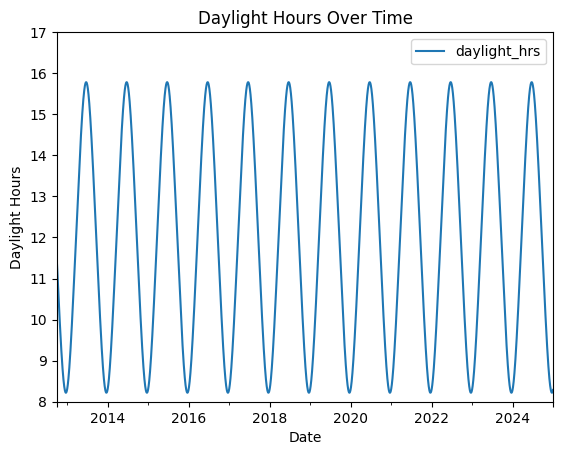

In [61]:
daily[['daylight_hrs']].plot()
plt.ylim(8, 17)
plt.title('Daylight Hours Over Time')
plt.ylabel('Daylight Hours')
plt.show()

**Daylight Hours Over Time**

The plot shows a clear cyclic pattern in daylight hours, corresponding to seasonal variations over multiple years.

Peaks represent summer months with maximum daylight, while troughs represent winter months with minimum daylight.

This visualization confirms the expected natural variations and provides insight into how daylight hours might influence bicycle usage.

# Convert temperatures (TMIN and TMAX) from tenths of degrees Celsius to Celsius

In [62]:
weather['TMIN'] /= 10
weather['TMAX'] /= 10
weather['Temp (C)'] = 0.5 * (weather['TMIN'] + weather['TMAX'])

# Convert precipitation from tenths of mm to inches

In [63]:
weather['PRCP'] /= 254
weather['dry day'] = (weather['PRCP'] == 0).astype(int)


# Join weather data with daily data

In [64]:
daily = daily.join(weather[['PRCP', 'Temp (C)', 'dry day']])


# Calculate 'annual' as the number of years since the start date

In [65]:
daily['annual'] = (daily.index - daily.index[0]).days / 365.0

# Drop rows with missing values

In [66]:
daily.dropna(axis=0, how='any', inplace=True)

In [67]:
daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day,annual
Date,,,,,,,,,,,,,,
2012-10-02,3876.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,11.335681,0.0,13.90,1.0,0.000000
2012-10-03,7042.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0.0,13.35,1.0,0.002740
2012-10-04,6950.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0.0,13.60,1.0,0.005479
2012-10-05,6296.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0.0,15.30,1.0,0.008219
2012-10-06,4012.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056,0.0,15.85,1.0,0.010959


# Data Visualization: Correlation Matrix

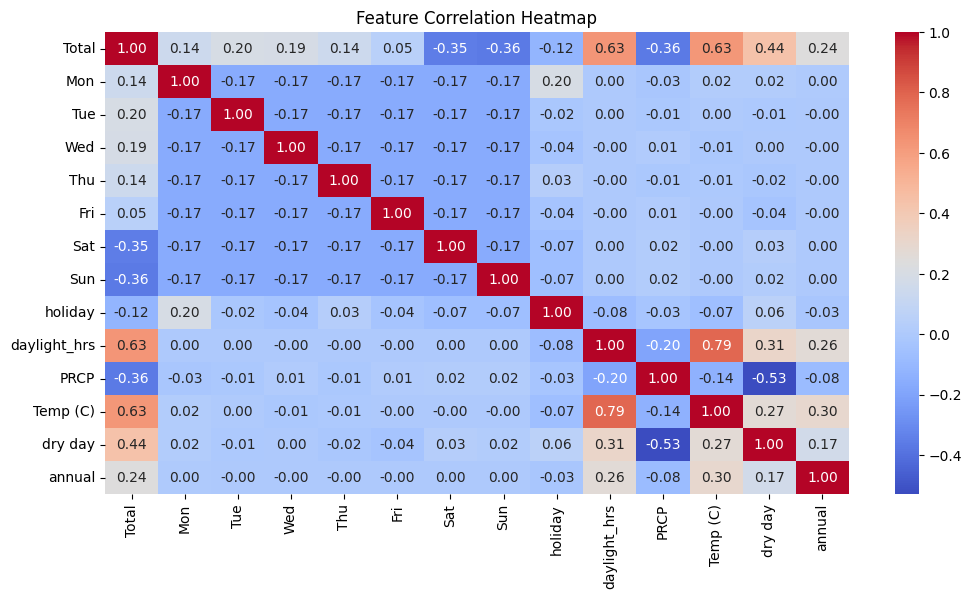

In [69]:
import seaborn as sns
plt.figure(figsize=(12, 6))
sns.heatmap(daily.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

**Feature Correlation Heatmap**

The heatmap provides a visual representation of feature correlations.
Key Observations:

Total bicycle counts positively correlate with daylight hours (0.63) and temperature (0.63), indicating that more people cycle when there is more daylight and higher temperatures.

Negative correlation between precipitation (-0.36) and total bicycle counts, meaning higher rainfall tends to reduce cycling activity.

"Dry day" has a moderate positive correlation (0.44) with total bicycle counts, reinforcing the idea that dry weather encourages cycling.

Weekdays have weak correlations, but weekends (Sat, Sun) show a slight negative correlation with bicycle counts, indicating lower usage compared to weekdays.

# Distribution of Total Bicycle Counts

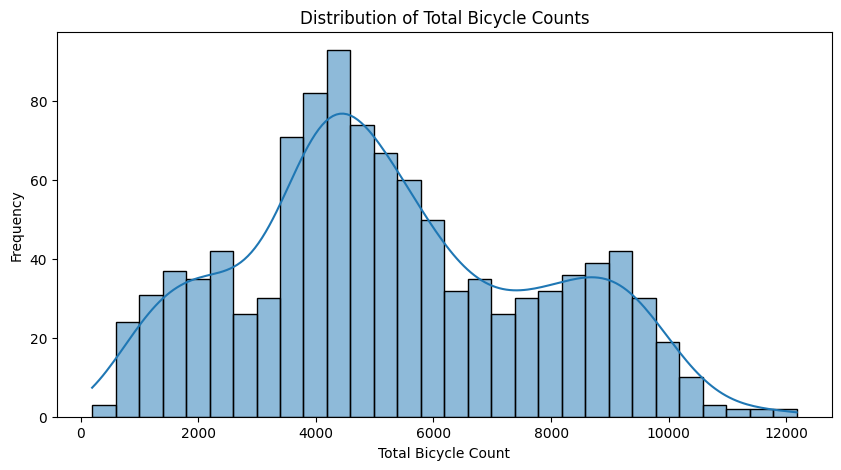

In [71]:
plt.figure(figsize=(10, 5))
sns.histplot(daily['Total'], bins=30, kde=True)
plt.title("Distribution of Total Bicycle Counts")
plt.xlabel("Total Bicycle Count")
plt.ylabel("Frequency")
plt.show()

**Distribution of Total Bicycle Counts**

The histogram shows a right-skewed distribution, indicating that most days have moderate bicycle counts, while a few days experience very high bicycle traffic.

The KDE (Kernel Density Estimate) plot helps visualize the overall distribution, confirming that extreme high-count days are relatively rare.

This suggests possible influencing factors like weather, events, or holidays affecting peak cycling days.

# Scatter Plot: Bicycle Count vs. Temperature


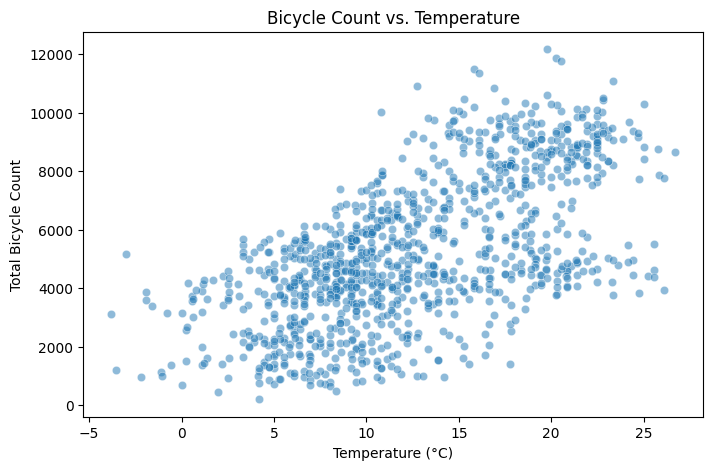

In [72]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x=daily['Temp (C)'], y=daily['Total'], alpha=0.5)
plt.title("Bicycle Count vs. Temperature")
plt.xlabel("Temperature (°C)")
plt.ylabel("Total Bicycle Count")
plt.show()

**Bicycle Count vs. Temperature**

The scatter plot exhibits a clear positive correlation between temperature and bicycle count.

When temperatures rise, bicycle counts generally increase.

The relationship is non-linear, with a noticeable spread in bicycle counts at higher temperatures, possibly due to additional factors like holidays or rain.

# Scatter Plot: Bicycle Count vs. Daylight Hours

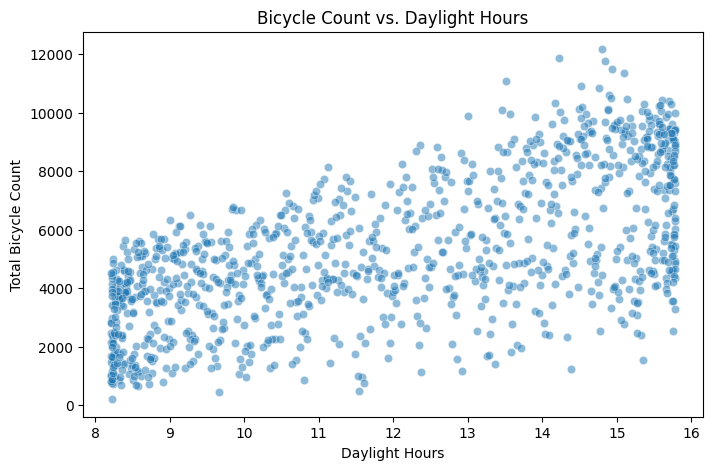

In [73]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x=daily['daylight_hrs'], y=daily['Total'], alpha=0.5)
plt.title("Bicycle Count vs. Daylight Hours")
plt.xlabel("Daylight Hours")
plt.ylabel("Total Bicycle Count")
plt.show()

**Bicycle Count vs. Daylight Hours**

A positive trend is visible: longer daylight hours are associated with increased bicycle counts.

However, there is significant spread, indicating that daylight is one of many factors affecting bicycle usage.

This confirms that daylight duration plays a crucial role, but other influences like temperature and precipitation are also important.

# Scatter Plot: Bicycle Count vs. Precipitation

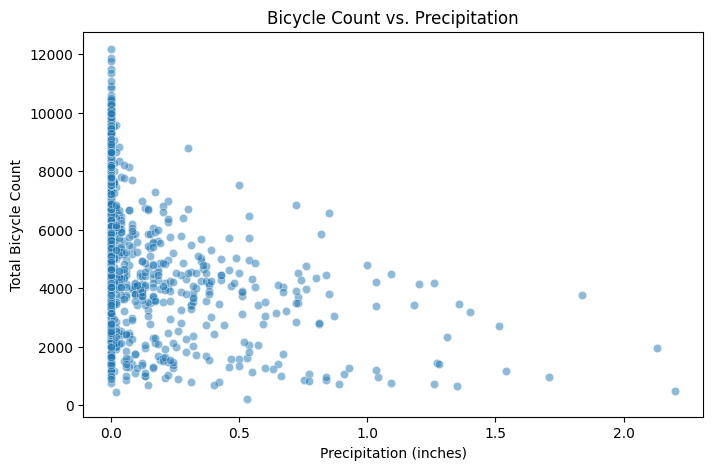

In [74]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x=daily['PRCP'], y=daily['Total'], alpha=0.5)
plt.title("Bicycle Count vs. Precipitation")
plt.xlabel("Precipitation (inches)")
plt.ylabel("Total Bicycle Count")
plt.show()

**Bicycle Count vs. Precipitation**

The scatter plot shows an inverse relationship: higher precipitation results in lower bicycle counts.

Many data points cluster at zero precipitation, reinforcing that most cycling happens on dry days.

Some extreme cases show cycling even with high precipitation, possibly due to events, committed cyclists, or infrastructure that supports all-weather cycling.

# Box Plot: Bicycle Counts by Day of the Week

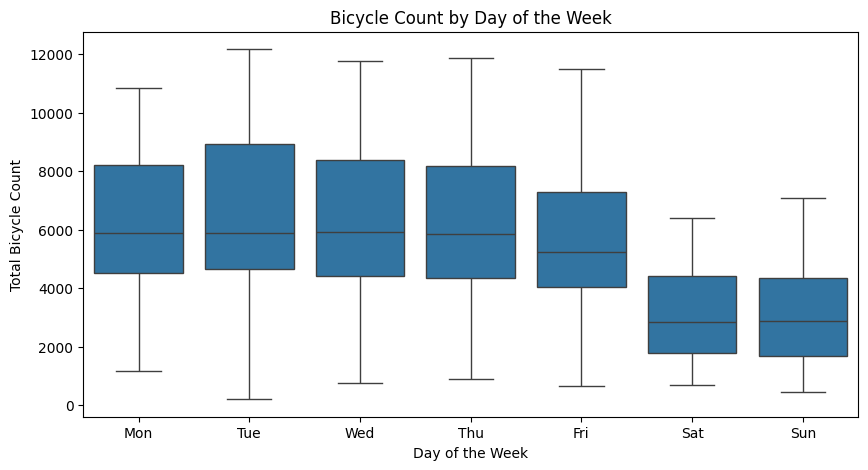

In [75]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=daily.index.dayofweek, y=daily['Total'])
plt.xticks(ticks=range(7), labels=days)
plt.title("Bicycle Count by Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Total Bicycle Count")
plt.show()

**Bicycle Count by Day of the Week (Box Plot)**

This box plot helps analyze the distribution of bicycle counts across weekdays and weekends.

**Key Observations:**

Monday to Friday exhibit higher median bicycle counts, indicating strong weekday commuting trends.

Saturday and Sunday have lower median counts and a wider range, likely reflecting more variability in leisure cycling behavior.

The distribution suggests that cycling is more consistent on weekdays (commuters) and more variable on weekends (recreational usage).

# Select features and target variable

In [76]:
column_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun','holiday', 'daylight_hrs', 'PRCP', 'dry day', 'Temp (C)', 'annual']
X = daily[column_names]
y = daily['Total']


# Split the data into training and test set

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the linear regression model

In [78]:
model = LinearRegression(fit_intercept=False)

# Fit the model

In [79]:
model.fit(X_train, y_train)

LinearRegression(fit_intercept=False)

# Make predictions on the test set

In [80]:
y_pred = model.predict(X_test)


# Evaluate the model

In [81]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


In [82]:
print(f'Mean Squared Error: {mse:.2f}')
print(f'R-squared: {r2:.2f}')

Mean Squared Error: 1010045.91
R-squared: 0.85


# Residual Plot

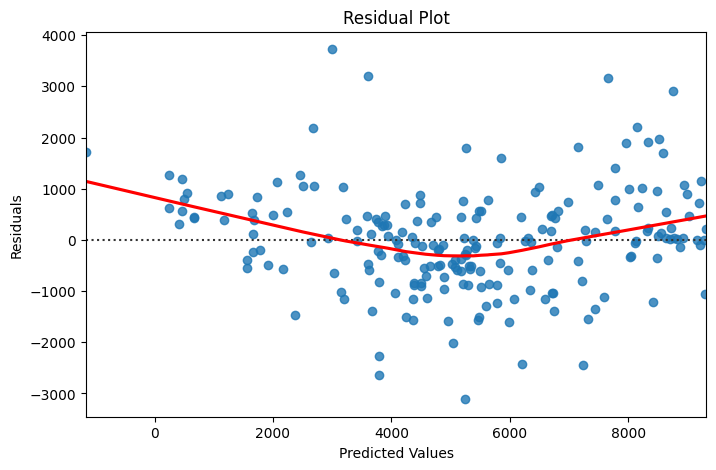

In [83]:
plt.figure(figsize=(8, 5))
sns.residplot(x=y_pred, y=y_test - y_pred, lowess=True, line_kws={'color': 'red'})
plt.title("Residual Plot")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()

# Plot the model's coefficients (feature importance)

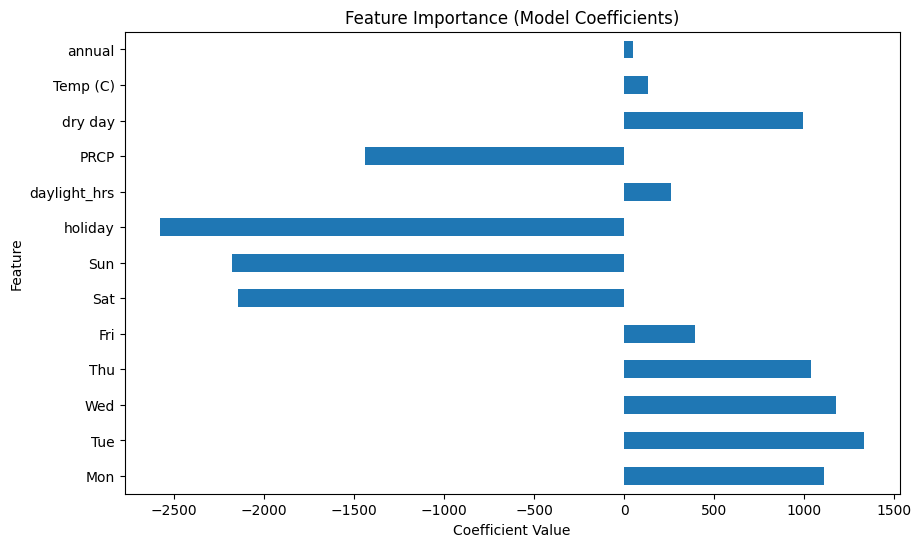

In [84]:
params = pd.Series(model.coef_, index=X.columns)
params.plot(kind='barh', figsize=(10, 6))
plt.title('Feature Importance (Model Coefficients)')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.show()

**Feature Importance (Model Coefficients)**

The bar chart represents the learned coefficients of the linear regression model.

**Key Takeaways:**

Weekdays have positive coefficients, confirming more cycling on these days.
Weekends (Sat, Sun) have negative coefficients, supporting the previous observation of reduced cycling on these days.

Holidays show a strong negative impact, meaning bicycle usage tends to drop significantly on holidays.

Daylight hours and temperature have positive effects, aligning with previous scatter plots showing their influence.

Precipitation has a strong negative effect, reinforcing that rain reduces cycling.

# Cross-validation

In [85]:
cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
print(f'Cross-validated MSE: {-cv_scores.mean():.2f}')

Cross-validated MSE: 976690.62


The cross-validated Mean Squared Error (MSE) is approximately 976,690.62, indicating the model's error level.

This helps assess how well the model generalizes to unseen data.

# Bootstrap Error Estimation

In [86]:

np.random.seed(1)
err = np.std([model.fit(*resample(X, y)).coef_ for i in range(1000)], 0)
print(pd.DataFrame({'effect': params.round(2), 'error': err.round(2)}))

               effect   error
Mon           1110.54  173.25
Tue           1333.28  168.92
Wed           1176.55  166.34
Thu           1038.07  162.87
Fri            390.79  159.35
Sat          -2146.66  160.61
Sun          -2179.94  163.07
holiday      -2580.97  326.67
daylight_hrs   260.07   17.34
PRCP         -1441.39  126.10
dry day        994.82   67.59
Temp (C)       128.96    7.12
annual          46.88   34.19


**Bootstrap Error Estimation**

The table displays coefficient estimates and their standard errors from bootstrap resampling.

**Key Insights:**

Features like daylight hours, temperature, and dry days have relatively low errors, suggesting strong reliability in their impact.

Holidays and weekends have larger errors, indicating their effect on bicycle counts might vary more due to additional factors like local events.

Precipitation has a significant negative effect with relatively stable error, reinforcing its strong impact.

# Final model prediction

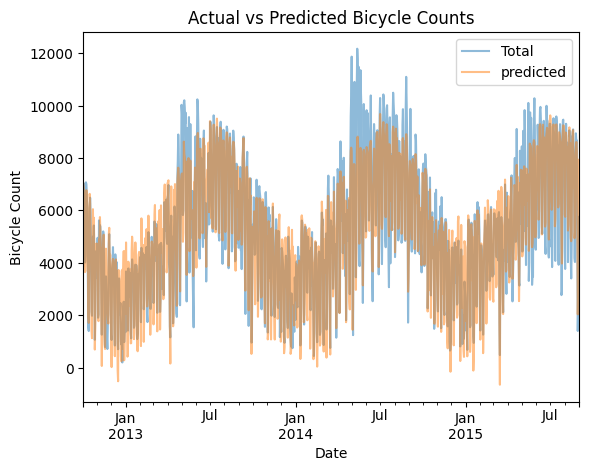

In [87]:
daily['predicted'] = model.predict(X)
daily[['Total', 'predicted']].plot(alpha=0.5)
plt.title('Actual vs Predicted Bicycle Counts')
plt.ylabel('Bicycle Count')
plt.xlabel('Date')
plt.show()

# Display model coefficients and errors

In [88]:
from sklearn.utils import resample
err = np.std([model.fit(*resample(X, y)).coef_ for i in range(1000)], 0)
print(pd.DataFrame({'effect': params.round(0), 'error': err.round(0)}))

              effect  error
Mon           1111.0  170.0
Tue           1333.0  164.0
Wed           1177.0  165.0
Thu           1038.0  171.0
Fri            391.0  163.0
Sat          -2147.0  168.0
Sun          -2180.0  167.0
holiday      -2581.0  322.0
daylight_hrs   260.0   18.0
PRCP         -1441.0  126.0
dry day        995.0   69.0
Temp (C)       129.0    7.0
annual          47.0   34.0


# Store predictions in DataFrame

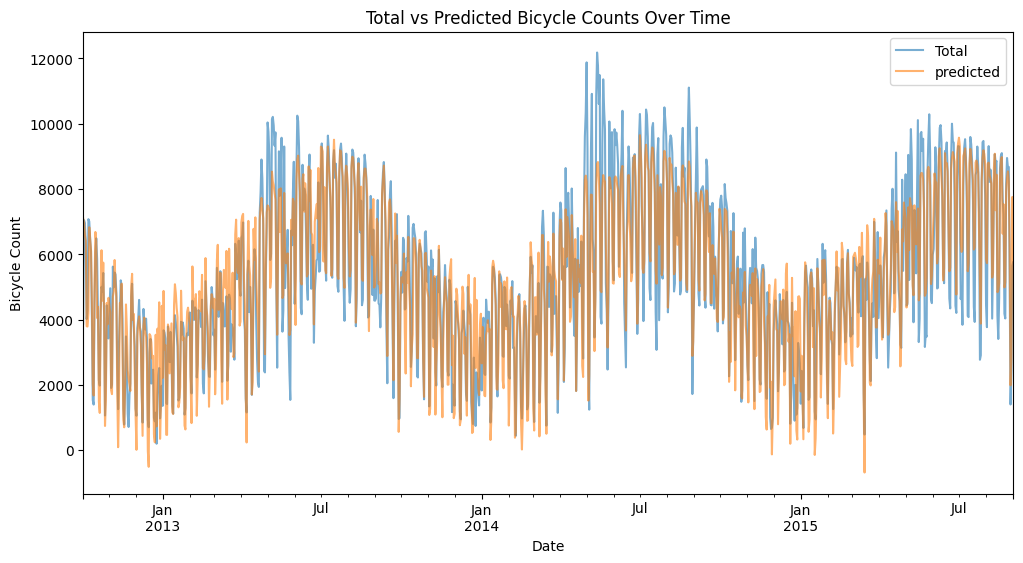

In [89]:
daily['predicted'] = model.predict(X)
daily[['Total', 'predicted']].plot(alpha=0.6, figsize=(12, 6))
plt.title("Total vs Predicted Bicycle Counts Over Time")
plt.ylabel("Bicycle Count")
plt.xlabel("Date")
plt.show()

#Final Thoughts & Next Steps

**1. The model effectively captures key trends, showing that temperature, daylight, precipitation, and day of the week significantly influence bicycle counts.**

**2. Some variation remains unexplained (e.g., weekend cycling behavior and holiday anomalies), suggesting further feature engineering (e.g., including local events or bike infrastructure changes).**

**3. Additional models like decision trees or gradient boosting could be tested for potentially better predictive performance.**

**4. The current analysis provides strong theoretical and practical insights into factors influencing bicycle usage.**